In [1]:
import torch
from torchvision import transforms
from test_tube import Experiment
from torchvision import transforms

In [2]:
import numpy as np

In [3]:
import argparse, os, json, sys
sys.path.insert(0,'/home/niell_lab/Documents/github/FreelyMovingEphys/')
from glob import glob
from tqdm import tqdm
from project_analysis.inception_loop.base import CorePlusReadout2d
from project_analysis.inception_loop.datasets import WorldcamDataset3D
from torch.utils.data import Dataset, DataLoader, Subset
from project_analysis.inception_loop.core import Stacked3dCore
import torch.nn as nn
import yaml

In [4]:
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
n = -1
modeltype = 'inceptionloop' 
filename = '/home/niell_lab/data/freely_moving_ephys/inception_loop/inceptionloop/version_1/config.yaml'
ckpt_path = glob('/home/niell_lab/data/freely_moving_ephys/inception_loop/inceptionloop/version_1/checkpoints/*.pt')[n]
with open(filename, 'r') as file:
    try:
        args = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

In [7]:
input_path = os.path.join(args['root_dir'], 'inputs')

In [8]:
SetRange = transforms.Lambda(lambda X: 2 * X - 1.)
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                            transforms.Resize((args['img_resize'],args['img_resize'])),
                            transforms.ToTensor(),
                            SetRange])

dataset = WorldcamDataset3D(args['csv'], args['history_size'], input_path, transform=transform)

num_units = len(eval(dataset.metadata['SR0'].iloc[0]))

startind = dataset.metadata.index[0]; endind = dataset.metadata.index[-1]; splitind = int((endind - startind) * args['split_frac'])

training_data = Subset(dataset,torch.arange(startind,splitind))
testing_data = Subset(dataset,torch.arange(splitind,endind))

train_dataloader = DataLoader(training_data, batch_size=args['batch_size'], num_workers=args['num_workers'], persistent_workers=True, pin_memory=True, prefetch_factor=5)
test_dataloader = DataLoader(testing_data, batch_size=args['batch_size'], num_workers=args['num_workers'])

model = Stacked3dCore(args['input_channels'], args['hidden_channels'], args['input_kern'], args['hidden_kern'], num_units, spike_history_len=args['history_size'], img_resize=args['img_resize'])
model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args['learning_rate'])

In [9]:
for key,val in torch.load(ckpt_path)['model_state_dict'].items():
    print(key, val.shape)

features.layer0.conv.weight torch.Size([2, 1, 7, 7, 7])
features.layer0.norm.weight torch.Size([2])
features.layer0.norm.bias torch.Size([2])
features.layer0.norm.running_mean torch.Size([2])
features.layer0.norm.running_var torch.Size([2])
features.layer0.norm.num_batches_tracked torch.Size([])
features.layer1.conv.weight torch.Size([2, 2, 7, 7, 7])
features.layer1.norm.weight torch.Size([2])
features.layer1.norm.bias torch.Size([2])
features.layer1.norm.running_mean torch.Size([2])
features.layer1.norm.running_var torch.Size([2])
features.layer1.norm.num_batches_tracked torch.Size([])
features.layer2.conv.weight torch.Size([2, 2, 7, 7, 7])
features.layer2.norm.weight torch.Size([2])
features.layer2.norm.bias torch.Size([2])
features.layer2.norm.running_mean torch.Size([2])
features.layer2.norm.running_var torch.Size([2])
features.layer2.norm.num_batches_tracked torch.Size([])
features.layerfc.weight torch.Size([12, 1024])
features.layerfc.bias torch.Size([12])


In [10]:
torch.load(ckpt_path)['model_state_dict']['features.layerfc.weight'].shape

torch.Size([12, 1024])

In [11]:
ckpt = torch.load(ckpt_path)

In [12]:
model.load_state_dict(ckpt['model_state_dict'])
model.eval()

Stacked3dCore(
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv3d(1, 2, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
      (norm): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (layer1): Sequential(
      (conv): Conv3d(2, 2, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
      (norm): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (layer2): Sequential(
      (conv): Conv3d(2, 2, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
      (norm): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (layerfc): Linear(in_features=1024, out_features=12, bias=True)
  )
) [Stacked3dCore regularizers: gamma_hidden = 0|gamma_input = 0.0]

In [13]:
from tqdm import tqdm

In [104]:
size = len(test_dataloader.dataset)
pred = np.zeros([64, 12, size]) # (unit number, frame)
actual = np.zeros([64, 12, size]) # (unit number, frame)
with torch.no_grad():
    n = 0
    for X, y in test_dataloader:
        X = X.to(device)
        this_pred = model(X)
        try:
            pred[:,:,n] = this_pred[:,:].cpu().numpy()
            actual[:,:,n] = y[:,-1,:].cpu().numpy()
        except ValueError as e:
            print(e)
            print(n, this_pred.shape, y.shape)
        n = n + 1

could not broadcast input array from shape (9,12) into shape (64,12)
785 torch.Size([9, 12]) torch.Size([9, 8, 12])


In [77]:
size = len(test_dataloader.dataset)
units = 12
batchsize = 64

pred = np.zeros([size*batchsize,units])
actual = np.zeros([size*batchsize,units])

with torch.no_grad():
    n = 0
    for X, y in tqdm(test_dataloader):
        X = X.to(device)
        this_pred = model(X) # this_pred: 64,12 ... and y: 64,8,12
        pred[n*64:(n+1)*64,:] = this_pred[:,:].cpu().numpy()
        actual[n*64:(n+1)*64,:] = y[:,-1,:].cpu().numpy()
        n = n + 1

100%|█████████▉| 785/786 [00:41<00:00, 18.77it/s]


ValueError: could not broadcast input array from shape (9,12) into shape (64,12)

100%|██████████| 12/12 [00:01<00:00,  8.92it/s]


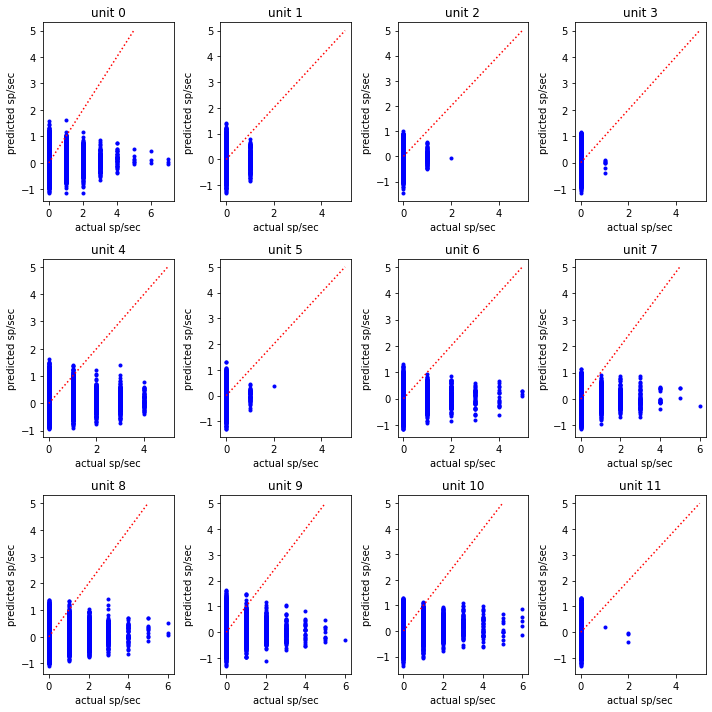

In [78]:
plt.subplots(3,4,figsize=[10,10])
for i in tqdm(range(12)):
    plt.subplot(3,4,i+1)
    plt.plot(actual[:,i],pred[:,i],'b.'); plt.plot([0,5],[0,5],'r:')
    plt.ylabel('predicted sp/sec'); plt.xlabel('actual sp/sec')
    plt.title('unit '+str(i))
plt.tight_layout()
plt.show()

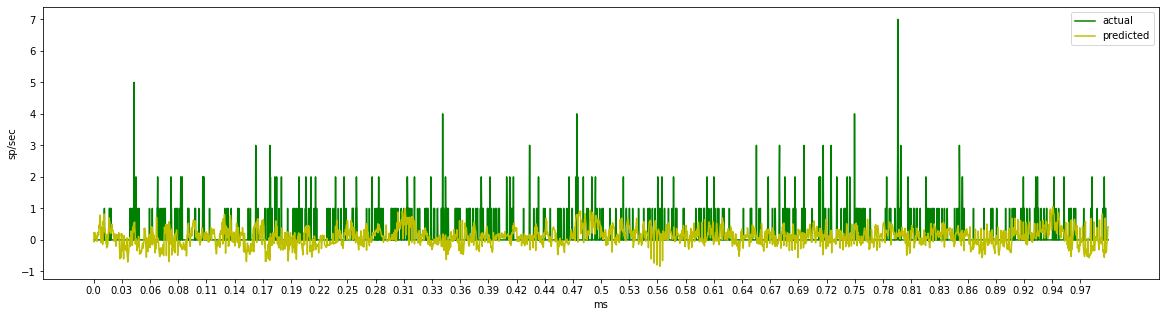

In [96]:
plt.figure(figsize=[20,5])
i = 0
plt.plot(actual[:3600,i], 'g-'); plt.plot(pred[:3600,i], 'y-')
plt.ylabel('sp/sec'); plt.xlabel('ms'); plt.xticks(ticks=np.arange(0,3600,100),labels=np.round(np.arange(0,1,1/36),2))
plt.legend(['actual','predicted'])

In [99]:
np.where(actual==7)

(array([ 2853,  9897, 11148]), array([0, 0, 0]))

In [101]:
np.where(actual==5)

(array([  143,   242,   255,  1668,  1818,  2708,  4448,  4978,  5023,
         7357,  7518,  7668, 10728, 10828, 10838, 11138, 11208, 11858,
        12148, 12278, 12307, 16109, 16173, 16187, 16237, 16250, 16272,
        16384, 16785, 16787, 16818, 17147, 17201, 17213, 17590, 17819,
        19787, 22237, 23816, 28465, 30046, 30103, 31908, 33513, 39238,
        49854]),
 array([ 0,  9,  8,  8,  8,  8, 10, 10, 10,  0,  9,  7,  9,  9,  7,  0,  0,
         8,  9, 10,  8,  6,  9,  6,  9,  8, 10, 10,  8,  9,  8,  7,  8,  9,
         6,  9,  0, 10,  0, 10, 10, 10,  8, 10,  6,  0]))